In [1]:
import torch 
from torch import nn
import matplotlib.pyplot as plt


from rbi.utils.nets import BernoulliNet
from rbi.loss.loss_fn import NLLLoss
from rbi.defenses.regularized_loss import GaussianNoiseJacobiRegularizer, WorstCaseJacobiRegularizer
from rbi.utils.datasets import get_datasets
from rbi.visualization.surface_plots import plot_2d_surface

torch.manual_seed(0)

In [2]:
train_loader, test_loader = get_datasets("binary", 2048, 4096)

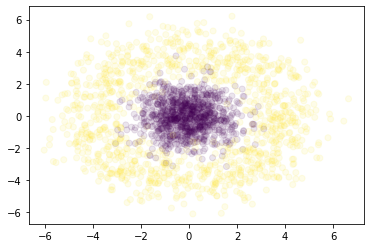

In [3]:
for X,y in train_loader:
    plt.scatter(X[:,0], X[:,1], c=y, alpha=0.1)

In [4]:
net1 = BernoulliNet(2)
loss_fn = NLLLoss(net1)

In [7]:
optim = torch.optim.Adam(net1.parameters(), lr=5e-3)
for i in range(3000):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%1000)==0:
        print(loss.detach())

tensor([0.5542])
tensor([0.1401])
tensor([0.0925])


c:\ProgramData\Miniconda3\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


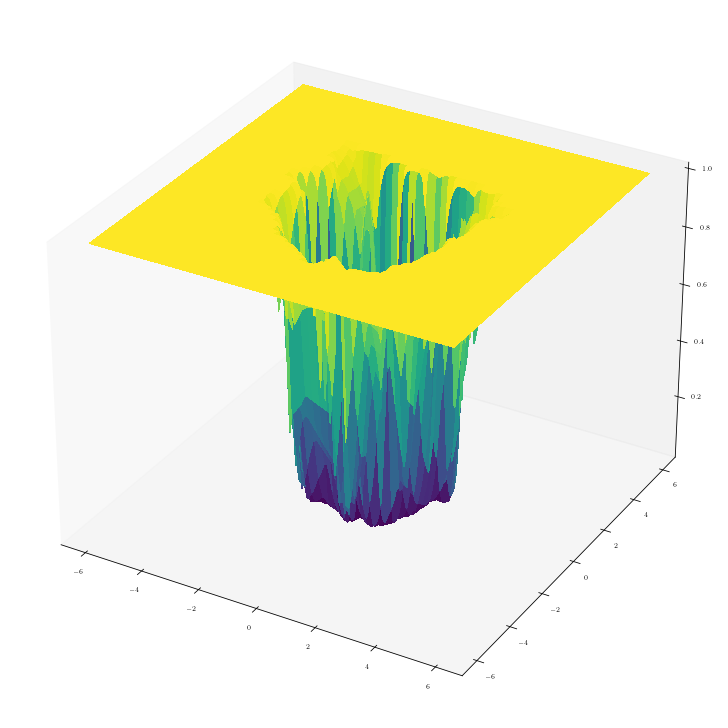

In [8]:
%matplotlib qt
%matplotlib inline
fig = plot_2d_surface(net1)

In [5]:
from rbi.defenses.regularized_pre_loss import L2PGDAdversarialTraining
from rbi.defenses.regularized_loss import L2PGDTrades

In [8]:
net2 = BernoulliNet(2)
loss_fn = NLLLoss(net2)
defense = L2PGDTrades(net2, loss_fn, eps=0.1)
defense.activate()

In [11]:
optim = torch.optim.Adam(net2.parameters(), lr=1e-4)
for i in range(500):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%20)==0:
        print(loss.detach())

tensor([0.5228])
tensor([0.4613])
tensor([0.4075])
tensor([0.3626])
tensor([0.3194])
tensor([0.2731])
tensor([0.2522])


KeyboardInterrupt: 

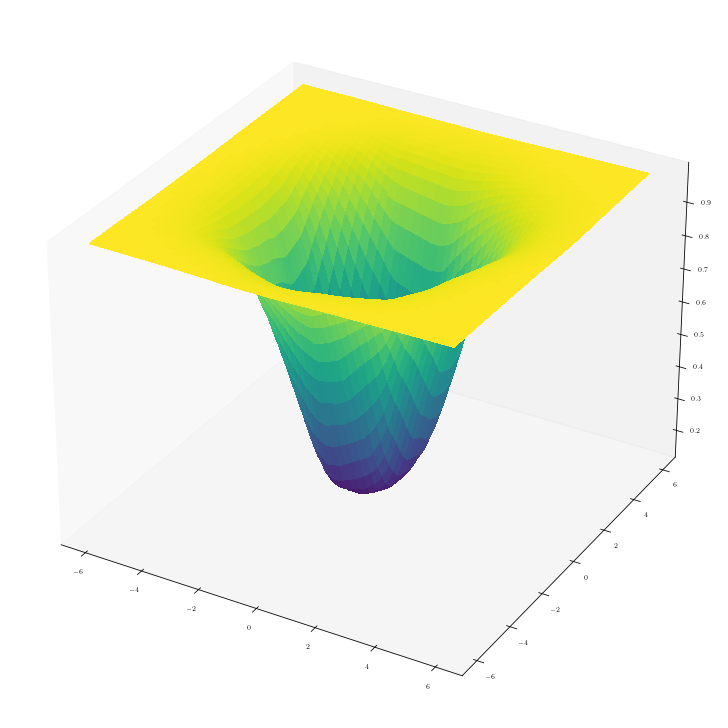

In [12]:
%matplotlib qt
%matplotlib inline
fig = plot_2d_surface(net2)

In [9]:
net2 = BernoulliNet(2, prediction_fn="argmax")
loss_fn = NLLLoss(net2)
defense = GaussianNoiseJacobiRegularizer(net2, loss_fn, 0.5)
defense.activate()

In [10]:
optim = torch.optim.Adam(net2.parameters(), lr=1e-3)
for i in range(3000):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%1000)==0:
        print(loss.detach())

tensor([0.6252])


KeyboardInterrupt: 

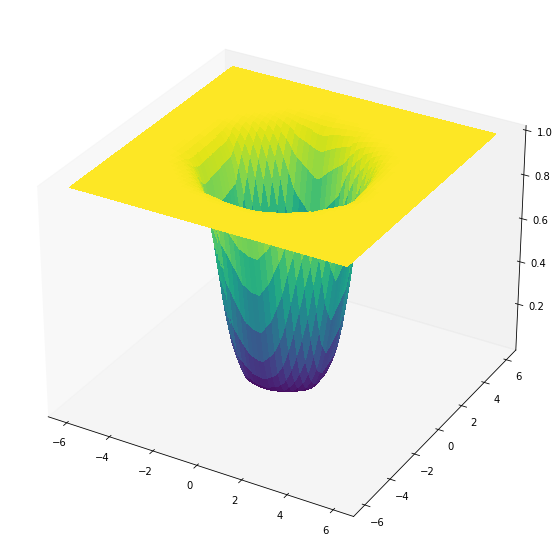

In [21]:
%matplotlib qt
%matplotlib inline
fig = plot_2d_surface(net2)

In [22]:
net3 = BernoulliNet(2, prediction_fn="argmax")
loss_fn = NLLLoss(net3)
defense = WorstCaseJacobiRegularizer(net3, loss_fn, 0.5)
defense.activate()

In [23]:
optim = torch.optim.Adam(net3.parameters(), lr=1e-3)
for i in range(3000):
    for X,y in train_loader:
        optim.zero_grad()
        loss = loss_fn(X, y)
        loss.backward()
        optim.step()
    if (i%1000)==0:
        print(loss.detach())

tensor(0.6672)
tensor(0.1619)
tensor(0.1460)


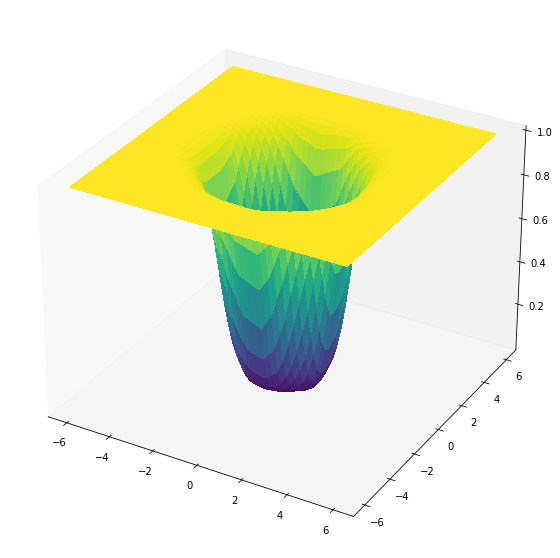

In [24]:
%matplotlib qt
%matplotlib inline
fig = plot_2d_surface(net3)

In [25]:
from rbi.attacks.advertorch_attack import L2PGDAttack
from rbi.attacks.custom_attacks import WhiteNoiseAttack
from rbi.metrics.empirical_metrics import EmpiricalAdversarialTestLossMetric
from rbi.loss.loss_fn import NegativeLogLikelihoodLoss, ForwardKLLoss

from rbi.visualization.robustness_eval_plots import plot_metric_for_pertubation_scales

In [26]:
adversarial_loss = ForwardKLLoss()
test_loss = NegativeLogLikelihoodLoss()

In [27]:
m1 = EmpiricalAdversarialTestLossMetric(net1, WhiteNoiseAttack(0.5), test_loss)
m2 = EmpiricalAdversarialTestLossMetric(net2, WhiteNoiseAttack(0.5), test_loss)
m3 = EmpiricalAdversarialTestLossMetric(net3, WhiteNoiseAttack(0.5), test_loss)

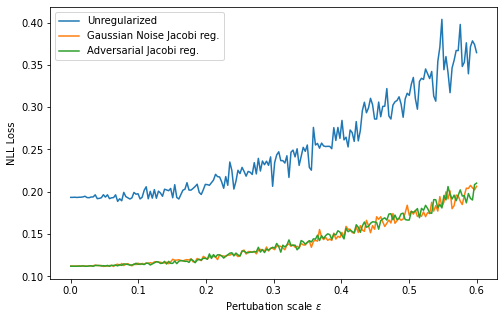

In [28]:
fig = plot_metric_for_pertubation_scales(torch.linspace(0, 0.6, 200), [m1,m2,m3], test_loader, legend_names=["Unregularized", "Gaussian Noise Jacobi reg.", "Adversarial Jacobi reg."])

In [29]:
m1 = EmpiricalAdversarialTestLossMetric(net1, L2PGDAttack(net1, adversarial_loss, nb_iter=100), test_loss)
m2 = EmpiricalAdversarialTestLossMetric(net2, L2PGDAttack(net2, adversarial_loss, nb_iter=100), test_loss)
m3 = EmpiricalAdversarialTestLossMetric(net3, L2PGDAttack(net3, adversarial_loss, nb_iter=100), test_loss)

In [30]:
m1.eval_perturbed(test_loader)

tensor(0.2262, grad_fn=<DivBackward0>)

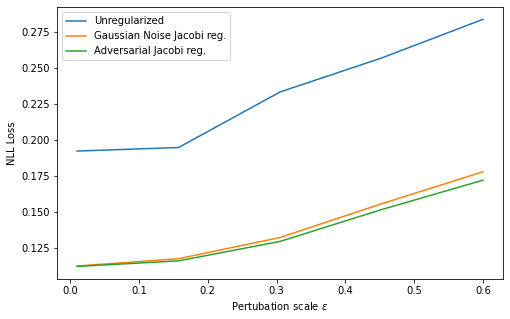

In [31]:
fig2 = plot_metric_for_pertubation_scales(torch.linspace(0.01, 0.6, 5), [m1,m2,m3], test_loader, legend_names=["Unregularized", "Gaussian Noise Jacobi reg.", "Adversarial Jacobi reg."])